This notebook documents my process of exploring the best ways to organize the data for the experimental design at hand. The main goal is to enable the efficient configuration of ablational studies on all important levels.

In [ ]:
from pathlib import Path

REPO_ROOT = Path("/home/emre/workspace/fedgenie3")
REPO_ROOT.exists()

In [ ]:
ROOT_BEELINE = REPO_ROOT / "data/raw/BEELINE"
ROOT_BEELINE.exists()

ROOT_BEELINE_DATA = ROOT_BEELINE / "BEELINE-data"
ROOT_BEELINE_NETWORKS = ROOT_BEELINE / "BEELINE-networks"

In [ ]:
ROOT_CURATED = ROOT_BEELINE_DATA / "inputs" / "Curated"
ROOT_CURATED.exists()

Assumptions about the datasets:
- **Synthetic Simulations**: There exists data simulated from synthetic boolean networks for 6 cell types (BF, BFC, CY, LI, LL, TF). For each of them, there exist $10 \text{ parameter sets} \times 5 \text{ sample size selections}$. The reference network varies across the parameter set axis and stays the same across the sample size axis.

- **Curated Simulations**: There exists data simulated from literature curated boolean networks for 4 cell types (GSD, HSC, mCAD, VSC). For each of them, there exist $10 \text{ parameter sets} \times 3 \text{ dropout rates}$. The reference network stays the same across the parameter set axis and varies (?) across the dropout rate axis.

- **scRNA-seq Datasets**: There exists data from single-cell RNA sequencing exists for 2 cell types in humans and 5 cell types in mouses. Each of them is associated to a single distinct gene expression matrix, a distinct gene ordering, distinct (e.g., `hESC-ChIP-seq-network.csv` for hESC only) as well as shared (, `STRING-Network.csv` for hESC and HepG2) collections of transciption factors that form a subset of the genes present in the gene expression matrix. 

**Question**: How to best adapt the datasets at hand to a federated setting?

In [ ]:
from fedgenie3.metrics import auroc, aupr, auroc_p_value, aupr_p_value
from fedgenie3.modeling import GENIE3
import numpy as np

y_true = np.array([0, 1, 1, 0, 1, 0, 1, 0, 1, 0])
y_pred = np.array([0.1, 0.9, 0.8, 0.3, 0.7, 0.2, 0.6, 0.4, 0.5, 0.1])

auroc(y_true, y_pred)
aupr(y_true, y_pred)
auroc_p_value(y_true, y_pred)
aupr_p_value(y_true, y_pred)

In [ ]:
from fedgenie3.modeling import genie3
import pandas as pd

# Load gene expression data
expression_matrix = pd.read_csv(
    "/home/emre/workspace/fedgenie3/data/raw/BEELINE/hESC-ExpressionData.csv",
    index_col=0,
)

### Synthetic datasets

In [ ]:
from typing import List
import pandas as pd

pd.options.plotting.backend = "plotly"

# Set root of the synthetic dataset directory
ROOT_BEELINE_SYNTHETIC = ROOT_BEELINE / "BEELINE-data" / "inputs" / "Synthetic"
ROOT_BEELINE_SYNTHETIC.exists()

ROOT_BEELINE_CURATED = ROOT_BEELINE / "BEELINE-data" / "inputs" / "Curated"
ROOT_BEELINE_CURATED.exists()

ROOT_BEELINE_RNASEQ = ROOT_BEELINE / "BEELINE-data" / "inputs" / "scRNA-Seq"
ROOT_BEELINE_RNASEQ.exists()

name = "hESC"
size = 2000

pattern_synthetic = f"{name}/{name}-{size}/ExpressionData.csv"
pattern_curated = f"{name}/{name}-2000-*/ExpressionData.csv"
pattern_rnaseq = f"{name}/ExpressionData.csv"

root_of_interest = ROOT_BEELINE_RNASEQ
pattern_of_interest = pattern_rnaseq


concat_df = pd.DataFrame()
for expr_data in root_of_interest.rglob(pattern_of_interest):
    df: pd.DataFrame = pd.read_csv(expr_data, index_col=0)
    df = df.transpose()
    df = (df - df.mean()) / df.std()
    print(f"Number of genes: {df.shape[1]}")
    print(f"Number of missing values: {df.isna().sum(axis=1).sum(axis=0)}")
    print(df.describe())
    # fig = df.plot(
    #     kind="box",
    #     title=f"Expression Data for {str(expr_data.parent.name)}",
    #     labels=dict(index="Gene", value="Expression Value")
    # )
    # fig.show()
    break

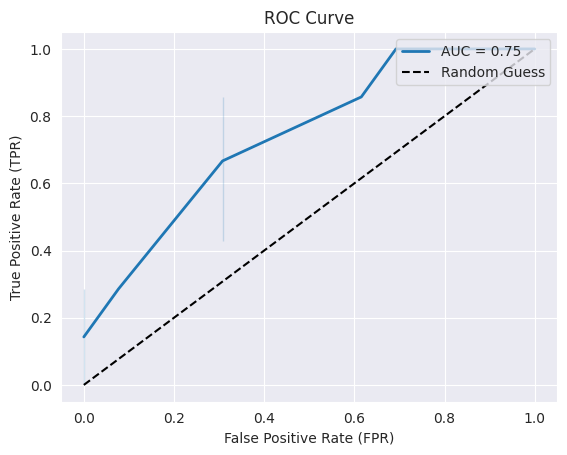

/home/emre/workspace/genie3/genie3/plot.py:56: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


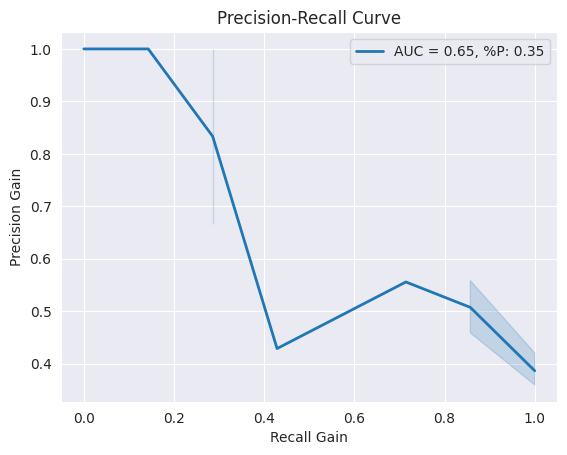

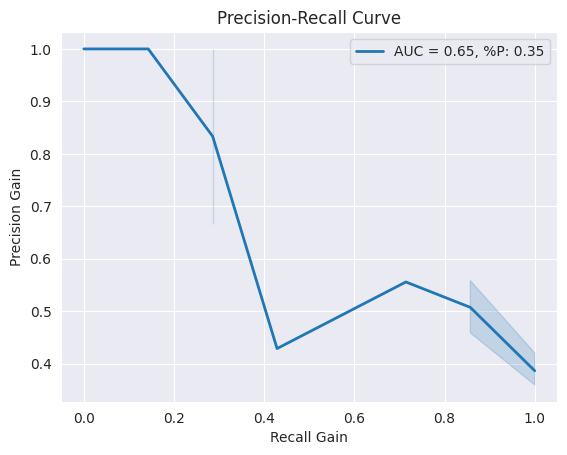

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from genie3.plot import plot_roc_curve, plot_precision_recall_curve
import seaborn as sns
import matplotlib

X, y = make_classification(
    n_samples=100, n_features=50, n_informative=40, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get prediction probabilities
y_scores = clf.predict_proba(X_test)[:, 1]

sns.set_style("darkgrid")
# Plot ROC and Precision-Recall curves
plot_roc_curve(y_test, y_scores)
plot_precision_recall_curve(y_test, y_scores)